# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [3]:
# !pip install datasets --upgrade
# !pip install evaluate
import os
import datasets


import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import torch.optim as optim
from transformers import get_scheduler

from tqdm.auto import tqdm
import random, math, time
import numpy as np


import transformers
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig,BertEncoder, BertModel

import evaluate

import matplotlib.pyplot as plt


datasets.__version__, transformers.__version__, torch.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


('2.18.0', '4.38.2', '2.2.1+cu121')

In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading our MNLI part of the GLUE dataset

Loaded dataset "mnli" from the GLUE benchmark, containing text pairs of premises and hypotheses.


In [5]:
###1. Load Dataset
task_to_keys = {
    "mnli": ("premise", "hypothesis"),
}
task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [6]:
raw_datasets['train'].features['label'].names

['entailment', 'neutral', 'contradiction']

In [7]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [8]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

## 2. Model & Tokenization

Identified the number of unique labels in the training set of the loaded dataset.


In [9]:

num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

<img src = "./figures/BERT_embed.png" width=500>

Initialized a BERT-based sequence classification model (`teacher_model`) and its tokenizer using the "bert-base-uncased" architecture.


In [10]:
teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id,
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing

Defined a tokenization function (`tokenize_function`) to process text pairs according to the specified task and tokenize them using the initialized tokenizer.


In [11]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

Applied the `tokenize_function` to tokenize the text pairs in the loaded dataset (`raw_datasets`) in batches.


In [12]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

Extracted the non-null keys from the task configuration for the specified task (`task_name`).


In [13]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

Removed specified columns ('premise', 'hypothesis', 'idx') from the tokenized datasets and renamed the 'label' column to 'labels', then set the format to PyTorch tensors.


In [14]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [15]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [16]:
tokenized_datasets['train'][0]['input_ids'].shape

torch.Size([28])

In [17]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

## 4. Preparing the dataloader

Defined a `data_collator` object, `DataCollatorWithPadding`, to dynamically pad input sequences. 
Subsequently, created smaller subsets of the train, validation, and test datasets by shuffling and selecting 1000, 100, and 100 examples each, respectively.



In [18]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [19]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(1000))
small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(100))
small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(100))

In [20]:

train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [21]:
for batch in train_dataloader:
    break

batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 79]), torch.Size([32, 79]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture
In the present work, the student - DistilBERT - has the same general architecture as BERT.
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2.
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers.
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher).
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [22]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

####
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [23]:

# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [24]:
configuration

{'return_dict': True,
 'output_hidden_states': False,
 'output_attentions': False,
 'torchscript': False,
 'torch_dtype': None,
 'use_bfloat16': False,
 'tf_legacy_loss': False,
 'pruned_heads': {},
 'tie_word_embeddings': True,
 'chunk_size_feed_forward': 0,
 'is_encoder_decoder': False,
 'is_decoder': False,
 'cross_attention_hidden_size': None,
 'add_cross_attention': False,
 'tie_encoder_decoder': False,
 'max_length': 20,
 'min_length': 0,
 'do_sample': False,
 'early_stopping': False,
 'num_beams': 1,
 'num_beam_groups': 1,
 'diversity_penalty': 0.0,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'typical_p': 1.0,
 'repetition_penalty': 1.0,
 'length_penalty': 1.0,
 'no_repeat_ngram_size': 0,
 'encoder_no_repeat_ngram_size': 0,
 'bad_words_ids': None,
 'num_return_sequences': 1,
 'output_scores': False,
 'return_dict_in_generate': False,
 'forced_bos_token_id': None,
 'forced_eos_token_id': None,
 'remove_invalid_values': False,
 'exponential_decay_length_penalty': None,
 'su

In [25]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [26]:
configuration

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

Defined a function `distill_bert_weights` to transfer knowledge from a BERT teacher model to a BERT student model, based on the specified initialization strategy. The function iterates through the layers of both models, selecting layers according to the chosen strategy and transferring weights accordingly.


In [27]:

def distill_bert_weights(teacher, student, init_strategy="top_k"):
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, init_strategy)
    elif isinstance(teacher, BertEncoder):
        teacher_layers = [layer for layer in next(teacher.children())]  # 12 layers from teacher
        student_layers = [layer for layer in next(student.children())]  # 6 layers for student

        if init_strategy == "top_k":
            selected_layers = range(len(student_layers))
        elif init_strategy == "bottom_k":
            selected_layers = range(len(teacher_layers) - len(student_layers), len(teacher_layers))
        elif init_strategy == "odd_layers":
            selected_layers = [i for i in range(len(teacher_layers)) if i % 2 == 0]
        elif init_strategy == "even_layers":
            selected_layers = [i for i in range(len(teacher_layers)) if i % 2 != 0]  #Python's zero-based indexing, this means checking for layers where i % 2 != 0.

        for i, idx in enumerate(selected_layers):
            student_layers[i].load_state_dict(teacher_layers[idx].state_dict())
    else:
        student.load_state_dict(teacher.state_dict())

    return student


In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Iterated through different initialization strategies for distilling BERT student models from the BERT teacher model. For each strategy, initialized a new student model, applied distillation weights, and calculated the percentage of student parameters relative to the teacher. Finally, stored the initialized student models for later use.


In [29]:
init_strategies = ["top_k", "bottom_k", "odd_layers",'even_layers']
student_models = {}

print(f'Teacher parameters: {count_parameters(teacher_model)}')

for strategy in init_strategies:
    # Initialize a new student model from the configuration
    student_model = type(teacher_model)(configuration).to(device)

    # Apply distillation weights based on the selected strategy
    student_model = distill_bert_weights(teacher=teacher_model, student=student_model, init_strategy=strategy)

    student_params = count_parameters(student_model)
    teacher_params = count_parameters(teacher_model)
    param_percentage = (student_params / teacher_params) * 100

    print(f'Student parameters (with {strategy} strategy): {student_params} (~{param_percentage:.2f}% of teacher)')

    # Store the initialized model for later use
    student_models[strategy] = student_model


Teacher parameters: 109484547
Student parameters (with top_k strategy): 66957315 (~61.16% of teacher)
Student parameters (with bottom_k strategy): 66957315 (~61.16% of teacher)
Student parameters (with odd_layers strategy): 66957315 (~61.16% of teacher)
Student parameters (with even_layers strategy): 66957315 (~61.16% of teacher)


- Teacher model has 109,484,547 parameters.
- Each student model, initialized with different strategies, has 66,957,315 parameters, which is approximately 61.16% of the teacher model's parameters.


### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

Defined a PyTorch module `DistillKL` to compute the knowledge-distillation (KD) loss between a student and a teacher model. The loss is calculated based on the Kullback-Leibler (KL) Divergence, considering the softmax outputs of both models. Hyperparameters include temperature and alpha for scaling the loss.


In [30]:

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities!
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits
        '''
        T = temperature #.cuda()

        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T

        return KD_loss

## 6. Training

- Set the number of epochs (`num_epochs`) and calculated the total number of training steps (`num_training_steps`) based on the number of epochs and update steps per epoch. 
- Defined knowledge distillation loss (`criterion_div`) using the `DistillKL` module and cosine embedding loss (`criterion_cos`). 
- Additionally, specified the learning rate (`lr`) as 5e-5.


In [33]:
num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()
lr = 5e-5

**Metric**

Loaded the appropriate evaluation metric function based on the task (`task_name`) from the GLUE benchmark using the `evaluate.load()` function. If no specific task is provided, the default evaluation metric is accuracy.


In [37]:
# Get the metric function
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

Initialized containers to store metrics for each strategy (`strategy_metrics`) with fields for

- training and evaluation losses, 
- classification loss, 
- distillation loss, and 
- cosine loss. 
    
Conducted training and evaluation loops for each strategy, computing and storing losses and accuracies at each epoch.


In [39]:
# Initialization of containers for metrics
strategy_metrics = {
    strategy: {'train_losses': [],
               'train_losses_cls': [],
               'train_losses_div': [],
               'train_losses_cos': [],
               'eval_losses': [],
               'eval_accuracies': []}
    for strategy in init_strategies
}

# Training and Evaluation Loop for Each Strategy
for strategy, model in student_models.items():
    model.to(device)
    teacher_model.to(device)

    print(f"\nTraining the student model with {strategy} strategy...")
    optimizer = optim.Adam(params=model.parameters(), lr=lr)
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_loss_cls, total_loss_div, total_loss_cos = 0, 0, 0, 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            outputs = model(**batch)
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            loss_cls = outputs.loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits, temperature=1)
            loss_cos = criterion_cos(outputs.logits, output_teacher.logits, torch.ones(outputs.logits.size(0), device=device))
            loss = (loss_cls + loss_div + loss_cos) / 3

            total_loss += loss.item()
            total_loss_cls += loss_cls.item()
            total_loss_div += loss_div.item()
            total_loss_cos += loss_cos.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        # Store losses for this epoch
        strategy_metrics[strategy]['train_losses'].append(total_loss / len(train_dataloader))
        strategy_metrics[strategy]['train_losses_cls'].append(total_loss_cls / len(train_dataloader))
        strategy_metrics[strategy]['train_losses_div'].append(total_loss_div / len(train_dataloader))
        strategy_metrics[strategy]['train_losses_cos'].append(total_loss_cos / len(train_dataloader))

        # Evaluation phase
        model.eval()
        total_eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                loss_cls = outputs.loss
                total_eval_loss += loss_cls.item()

                predictions = outputs.logits.argmax(dim=-1)
                metric.add_batch(predictions=predictions, references=batch["labels"])

        eval_metric = metric.compute()
        strategy_metrics[strategy]['eval_losses'].append(total_eval_loss / len(eval_dataloader))
        strategy_metrics[strategy]['eval_accuracies'].append(eval_metric['accuracy'])

        print(f"Strategy: {strategy}, Epoch: {epoch+1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader):.4f}, Validation Loss: {total_eval_loss / len(eval_dataloader):.4f}, Validation Accuracy: {eval_metric['accuracy']:.4f}")



Training the student model with top_k strategy...
Strategy: top_k, Epoch: 1/5, Training Loss: 0.3912, Validation Loss: 1.0334, Validation Accuracy: 0.4400
Strategy: top_k, Epoch: 2/5, Training Loss: 0.3547, Validation Loss: 0.9488, Validation Accuracy: 0.5500
Strategy: top_k, Epoch: 3/5, Training Loss: 0.3220, Validation Loss: 0.9238, Validation Accuracy: 0.6300
Strategy: top_k, Epoch: 4/5, Training Loss: 0.2975, Validation Loss: 0.8984, Validation Accuracy: 0.5900
Strategy: top_k, Epoch: 5/5, Training Loss: 0.2823, Validation Loss: 0.9019, Validation Accuracy: 0.5800

Training the student model with bottom_k strategy...
Strategy: bottom_k, Epoch: 1/5, Training Loss: 0.3893, Validation Loss: 1.1024, Validation Accuracy: 0.2900
Strategy: bottom_k, Epoch: 2/5, Training Loss: 0.3828, Validation Loss: 1.1040, Validation Accuracy: 0.3400
Strategy: bottom_k, Epoch: 3/5, Training Loss: 0.3829, Validation Loss: 1.1061, Validation Accuracy: 0.3300
Strategy: bottom_k, Epoch: 4/5, Training Loss:

In [40]:
for strategy, metrics in strategy_metrics.items():
        avg_validation_accuracy = sum(metrics['eval_accuracies']) / len(metrics['eval_accuracies'])
        print(f"Average Validation Accuracy for {strategy}: {avg_validation_accuracy:.4f}")


Average Validation Accuracy for top_k: 0.5580
Average Validation Accuracy for bottom_k: 0.3380
Average Validation Accuracy for odd_layers: 0.4740
Average Validation Accuracy for even_layers: 0.4260


In [41]:
# Assuming strategy_metrics dictionary is populated with final metrics for 'top_k', 'bottom_k', 'odd_layers', and 'even_layers'

# Initialize summary table
summary_table = {
    "Strategy": ["Top-K Layer", "Bottom-K Layer", "Odd Layer", "Even Layer"],
    "Training Loss": [],
    "Validation Loss": [],
    "Validation Accuracy": []
}

# Populate the summary table with the final metrics from each strategy
for strategy, friendly_name in zip(["top_k", "bottom_k", "odd_layers", "even_layers"], summary_table["Strategy"]):
    if strategy in strategy_metrics:  # Check if the strategy was used
        metrics = strategy_metrics[strategy]
        summary_table["Training Loss"].append(metrics['train_losses'][-1])  # Last training loss
        summary_table["Validation Loss"].append(metrics['eval_losses'][-1])  # Last validation loss
        summary_table["Validation Accuracy"].append(metrics['eval_accuracies'][-1])  # Last validation accuracy
    else:
        # Fill with NaN or placeholders if the strategy wasn't used
        summary_table["Training Loss"].append("N/A")
        summary_table["Validation Loss"].append("N/A")
        summary_table["Validation Accuracy"].append("N/A")

# Display the summary table
print("Summary of Results by Strategy")
print("-" * 80)
print("{:<20} {:<20} {:<20} {:<20}".format('Student Layer', 'Training Loss', 'Validation Loss', 'Validation Accuracy'))
for i in range(len(summary_table["Strategy"])):
    print("{:<20} {:<20} {:<20} {:<20}".format(
        summary_table["Strategy"][i],
        f"{summary_table['Training Loss'][i]:.4f}" if summary_table['Training Loss'][i] != "N/A" else "N/A",
        f"{summary_table['Validation Loss'][i]:.4f}" if summary_table['Validation Loss'][i] != "N/A" else "N/A",
        f"{summary_table['Validation Accuracy'][i]:.4%}" if summary_table['Validation Accuracy'][i] != "N/A" else "N/A"
    ))


Summary of Results by Strategy
--------------------------------------------------------------------------------
Student Layer        Training Loss        Validation Loss      Validation Accuracy 
Top-K Layer          0.2823               0.9019               58.0000%            
Bottom-K Layer       0.3603               1.1181               38.0000%            
Odd Layer            0.3042               0.9772               47.0000%            
Even Layer           0.3144               1.0152               51.0000%            


Summary and Analysis of Initial Layer Selection Impact on Performance:

| Student Layer   | Training Loss | Validation Loss | Validation Accuracy | Performance Impact |
|-----------------|---------------|-----------------|---------------------|-------------------|
| Top-K Layer     | 0.2823        | 0.9019          | 58.0000%            | Higher validation accuracy compared to other strategies, indicating that initializing with top layers captures more relevant information from the teacher model. However, higher validation loss suggests potential overfitting or complexity. |
| Bottom-K Layer  | 0.3603        | 1.1181          | 38.0000%            | Lower validation accuracy compared to other strategies, implying that initializing with bottom layers might not capture sufficient relevant information from the teacher model. Higher validation loss suggests either underfitting or inadequate model complexity. |
| Odd Layer       | 0.3042        | 0.9772          | 47.0000%            | Moderate validation accuracy and loss. Initializing with odd layers balances between capturing relevant information and model complexity, resulting in intermediate performance. |
| Even Layer      | 0.3144        | 1.0152          | 51.0000%            | Slightly better validation accuracy compared to odd layers but still lower than top-K layer. Initializing with even layers demonstrates performance between odd layers and top layers, suggesting a moderate capture of relevant information. |

Overall, the choice of initial layer selection significantly impacts the performance of the student model. The top-K layer initialization tends to perform best, likely due to capturing the most relevant information from the teacher model, while bottom-K layer initialization performs the worst. Odd and even layer initializations offer a balance between capturing relevant information and model complexity.


Plotted the training and validation losses for each strategy using the collected `strategy_metrics`. Additionally, included the validation accuracy plot if available.


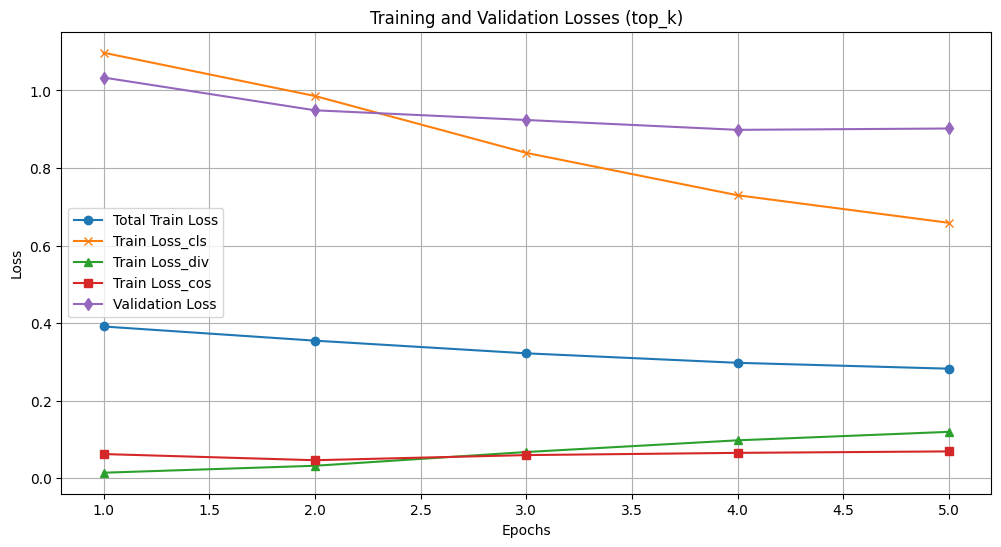

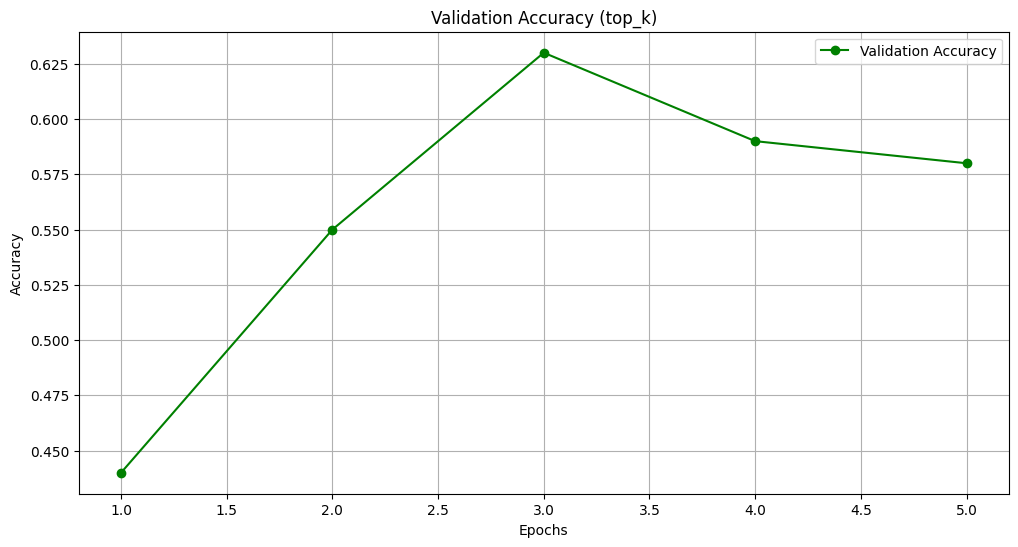

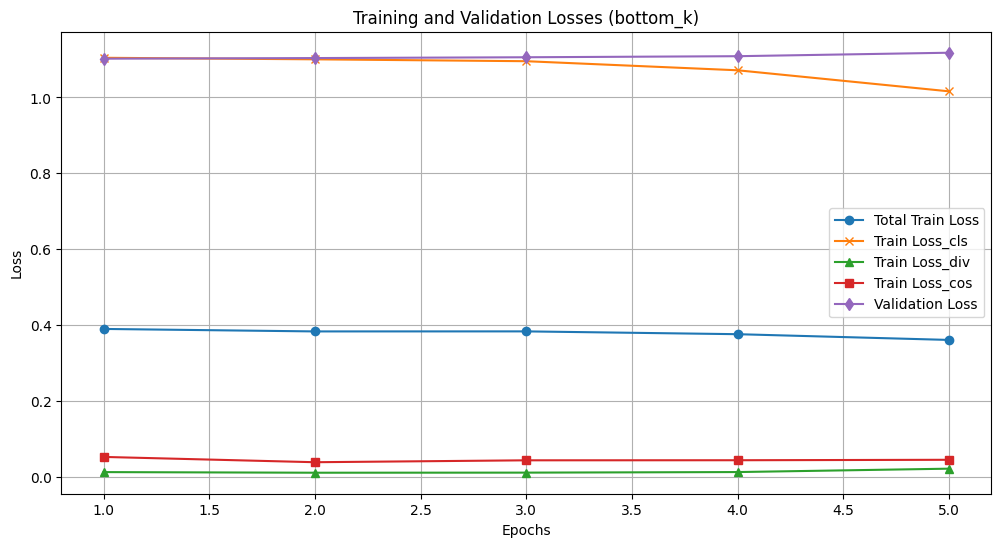

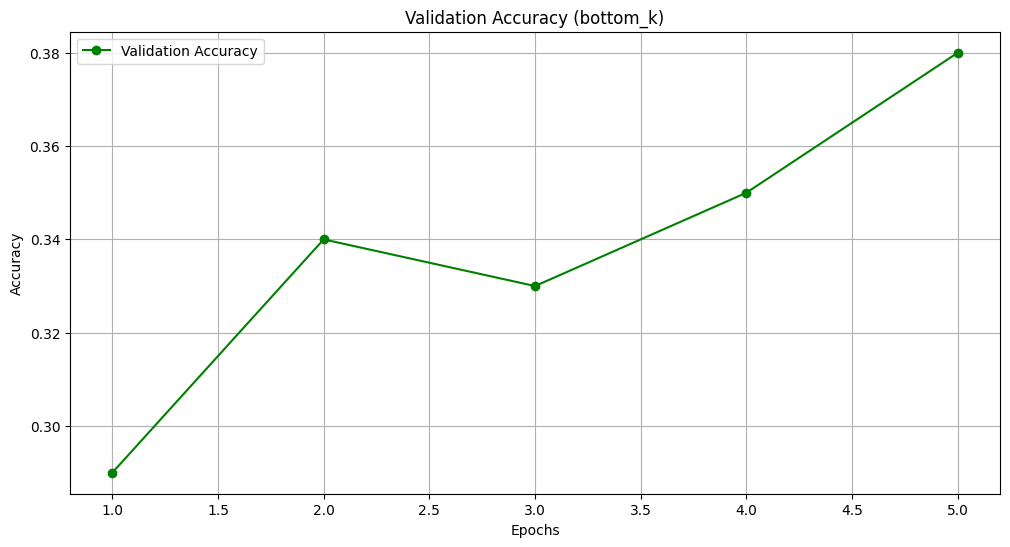

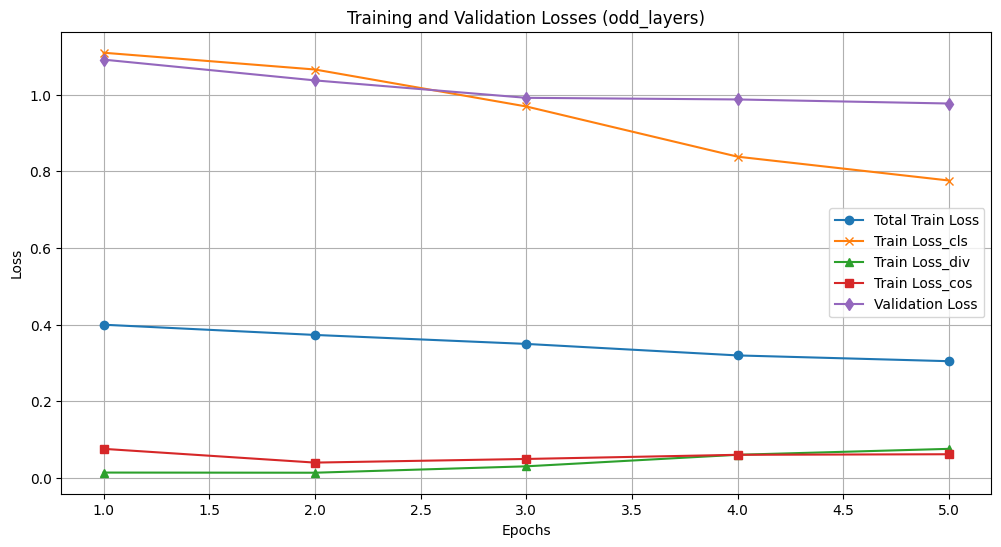

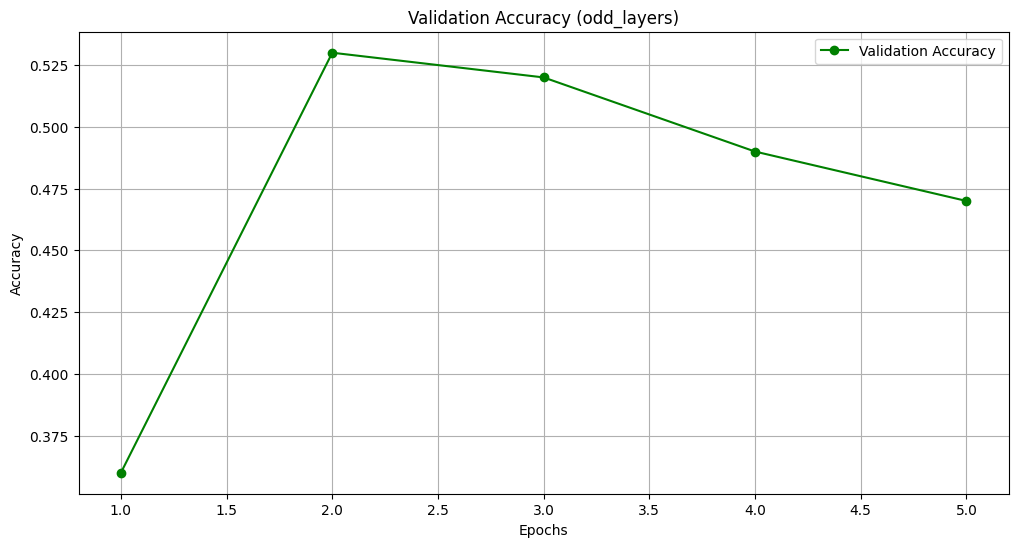

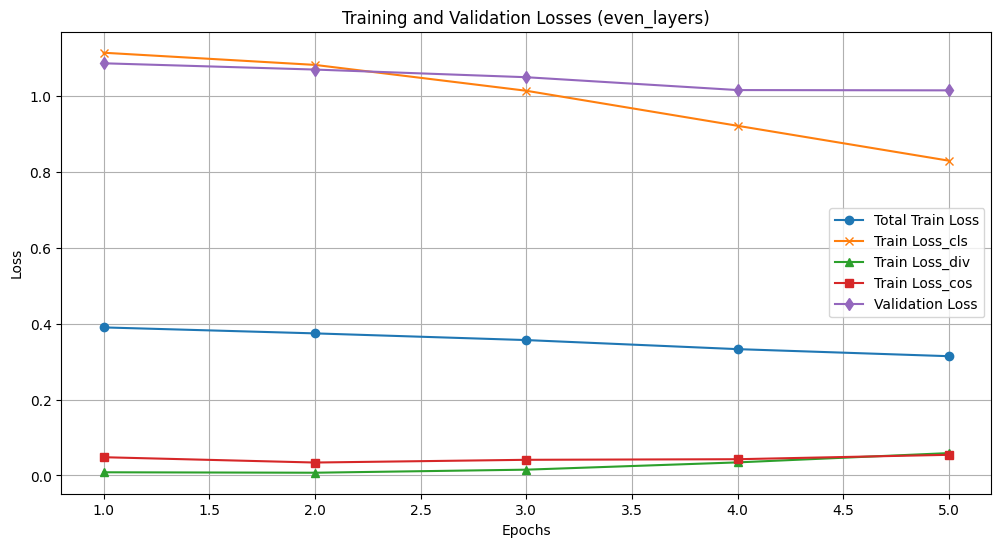

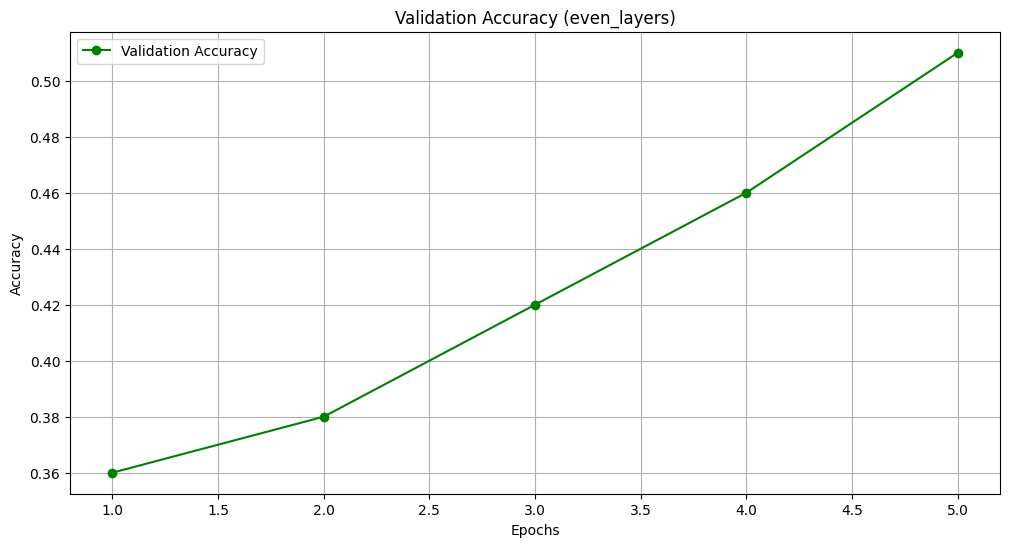

In [42]:
for strategy, metrics in strategy_metrics.items():
    epochs_list = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, metrics['train_losses'], label='Total Train Loss', marker='o')
    plt.plot(epochs_list, metrics['train_losses_cls'], label='Train Loss_cls', marker='x')
    plt.plot(epochs_list, metrics['train_losses_div'], label='Train Loss_div', marker='^')
    plt.plot(epochs_list, metrics['train_losses_cos'], label='Train Loss_cos', marker='s')
    plt.plot(epochs_list, metrics['eval_losses'], label='Validation Loss', marker='d')

    plt.title(f'Training and Validation Losses ({strategy})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

   
    if 'eval_accuracies' in metrics:
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_list, metrics['eval_accuracies'], label='Validation Accuracy', marker='o', color='green')
        plt.title(f'Validation Accuracy ({strategy})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

### Appendix (Teacher Model)

Executed the training loop for the teacher model over the specified number of epochs (`num_epochs`). Utilized the Adam optimizer with a learning rate of 5e-5. Tracked the training loss and evaluated the model's performance on the test dataset at each epoch. Finally, calculated and displayed the average accuracy across all epochs.


In [43]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn

lr = 5e-5
#training hyperparameters
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_teacher = teacher_model(**batch)
        # cls loss
        loss = output_teacher.loss
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')

    teacher_model.eval()
    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = teacher_model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions,
            references=batch["labels"])

    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy']
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")

print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch at 1: Train loss 1.0502:
Epoch at 1: Test Acc 0.5500
Epoch at 2: Train loss 0.7466:
Epoch at 2: Test Acc 0.6800
Epoch at 3: Train loss 0.4468:
Epoch at 3: Test Acc 0.6000
Epoch at 4: Train loss 0.2254:
Epoch at 4: Test Acc 0.7200
Epoch at 5: Train loss 0.0999:
Epoch at 5: Test Acc 0.6300
Avg Metric 0.6359999999999999


### Summary of Results by Strategy

| Student Layer   | Training Loss | Validation Loss | Validation Accuracy |
|-----------------|---------------|-----------------|---------------------|
| Top-K Layer     | 0.2823        | 0.9019          | 58.0000%            |
| Bottom-K Layer  | 0.3603        | 1.1181          | 38.0000%            |
| Odd Layer       | 0.3042        | 0.9772          | 47.0000%            |
| Even Layer      | 0.3144        | 1.0152          | 51.0000%            |

**Teacher Model Average Metric**: 0.636

### Limitations and Challenges:

1. **Interpretability of Initial Layer Selection**: While the results provide insights into the impact of different initialization strategies, interpreting why certain strategies perform better than others can be challenging. Understanding the underlying dynamics of layer selection and its interaction with model architecture is crucial but complex.

2. **Sensitivity to Hyperparameters**: The performance of student distillation is highly sensitive to hyperparameters such as learning rate, temperature, and batch size. Suboptimal hyperparameter choices can lead to subpar performance across all strategies.

3. **Overfitting and Underfitting**: Balancing between overfitting and underfitting during distillation is non-trivial. Strategies that initialize with fewer layers might underfit, while strategies with more layers might overfit, leading to a trade-off between capturing relevant information and model complexity.

### Proposed Improvements:

1. **Comprehensive Hyperparameter Search**: Conducting a systematic hyperparameter search to find optimal values for learning rate, temperature, and other parameters can enhance the performance of all strategies. Techniques such as grid search or random search can be employed for this purpose.

2. **Regularization Techniques**: Introducing regularization techniques like dropout or weight decay can help mitigate overfitting issues, especially for strategies that initialize with a larger number of layers.

3. **Dynamic Layer Initialization**: Rather than relying on static layer selection strategies (e.g., top-K, bottom-K), implementing dynamic layer initialization methods that adaptively select layers based on their relevance to the task can potentially improve performance.

4. **Ensemble of Student Models**: Instead of relying on a single student model, constructing an ensemble of student models initialized with different strategies and combining their predictions can lead to more robust and accurate results.

By addressing these limitations and incorporating proposed improvements, the student distillation process can be made more effective and robust, ultimately enhancing its ability to transfer knowledge from teacher to student models effectively.


Saved the teacher model, each student model, and the tokenizer to the specified directory (`save_directory`). The teacher model is saved as "teacher_model", and each student model is saved with a name corresponding to its initialization strategy (e.g., "student_model_top_k"). The tokenizer is saved as "tokenizer". 


In [ ]:
# Define the directory where we want to save the models and tokenizer
save_directory = "./app/models/"

# if not os.path.exists(save_directory):
#     os.makedirs(save_directory)

# Save the teacher model
teacher_save_path = os.path.join(save_directory, "teacher_model")
teacher_model.save_pretrained(teacher_save_path)

# Save each student model
for strategy, model in student_models.items():
    student_save_path = os.path.join(save_directory, f"student_model_{strategy}")
    model.save_pretrained(student_save_path)

# Save the tokenizer
tokenizer_save_path = os.path.join(save_directory, "tokenizer")
tokenizer.save_pretrained(tokenizer_save_path)

print("Models and tokenizer have been saved.")


In [2]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Define the directory where we saved the models and tokenizer
load_directory = './app/models'

# Load the teacher model
teacher_model_path = os.path.join(load_directory, "teacher_model")
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_model_path)

# Load student models
student_models = {}
strategies = ["top_k", "bottom_k", "odd_layers", "even_layers"]
for strategy in strategies:
    model_path = os.path.join(load_directory, f"student_model_{strategy}")
    student_models[strategy] = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load the tokenizer
tokenizer_path = os.path.join(load_directory, "tokenizer")
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)


In [9]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# id2label = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
# Move models to the correct device
teacher_model = teacher_model.to(device)
for strategy, model in student_models.items():
    student_models[strategy] = model.to(device)

# Define the input text
input_text = "African Products are always authentic."

# Tokenize the input text and move to the correct device
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform inference with the teacher model
teacher_model.eval()
with torch.no_grad():
    outputs = teacher_model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)
    predicted_label = teacher_model.config.id2label[predictions.item()]
    print(f"Output for Teacher model: {predicted_label}")

# Perform inference with each student model
for strategy, model in student_models.items():
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        predicted_label = model.config.id2label[predictions.item()]
        print(f"Output for {strategy} strategy: {predicted_label}")


Output for Teacher model: neutral
Output for top_k strategy: contradiction
Output for bottom_k strategy: contradiction
Output for odd_layers strategy: contradiction
Output for even_layers strategy: neutral
